In [3]:
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline
from torch.utils import data
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 加载数据

In [4]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx .

Load datasets/CALCE/CS2_38\CS2_38_10_14_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_21_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_28_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_01_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_08_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_15_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_22_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_24_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_06_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_13_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_20_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_23_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_18_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_24_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_28_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_4_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_8_17_10.xlsx ...
Load datasets/CALCE/

## 画出数据

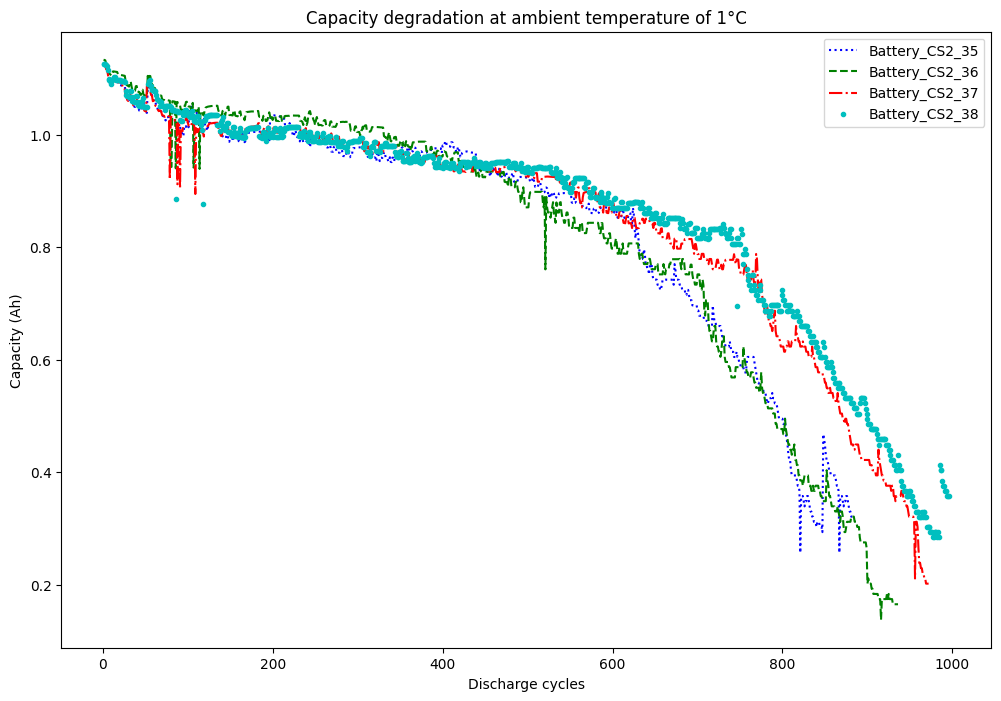

In [5]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

## 构建数据

In [6]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + window_size]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v['capacity'], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 评估函数

In [7]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 测试 train_iter 的数据是否正确

In [8]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, y in train_iter:
        print(X.shape)
        print(y.shape)
        print(X[1])
        print(y[1])
        break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

## 随机种子

In [9]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 模型

In [10]:
# 模型
class Net(nn.Module):
    def __init__(self, window_size, hidden_dim, num_layers, mode='LSTM', n_class=1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.cell = nn.LSTM(input_size=window_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=window_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=window_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_dim, n_class)

    def forward(self, x):  # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x)
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)  # out shape: (batch_size, n_class=1)
        return out

## 测试模型的输出形状

In [11]:
# 测试模型的输出形状
def validate_model_output_shape(net, X):
    test_y_hat = net(X)
    print(test_y_hat.shape)
    print(test_y_hat[0, 0])

# test_x = torch.ones((1, 1, 16))
# validate_model_output_shape(net, test_x)

## 一个批次的训练函数

In [12]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, y in train_iter:
        # 计算梯度并更新参数
        X = torch.reshape(X / Rated_Capacity, (-1, 1, window_size)).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, 1)).type(torch.float32)
        X, y = X.to(device), y.to(device)
        
        y_hat = net(X)
        l = loss(y_hat, y)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [16]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
        
        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
        
        if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)
            
        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
        #     break

        
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [14]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = torch.from_numpy(x).to(device)  # shape: (batch_size, 1, input_size)
        pred = net(x).cpu()
        next_point = pred.data.numpy()[0, 0] * Rated_Capacity
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

## RNN 模型 开始训练

In [19]:
# 电池额定容量
Rated_Capacity = 1.1

# 模型
mode = 'RNN'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 100
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 64

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_35, epoch:1    , loss:0.0053503937 , MAE:0.2019 , RMSE:0.2877 , RE:0.4177 , R2:-0.9449
seed: 0, 测试集: CS2_35, epoch:2    , loss:0.0041449135 , MAE:0.1697 , RMSE:0.1962 , RE:0.4177 , R2:0.0959
seed: 0, 测试集: CS2_35, epoch:4    , loss:0.0029297685 , MAE:0.1545 , RMSE:0.1942 , RE:0.4177 , R2:0.1137
seed: 0, 测试集: CS2_35, epoch:7    , loss:0.0038382933 , MAE:0.1476 , RMSE:0.1940 , RE:0.4177 , R2:0.1158
seed: 0, 测试集: CS2_35, epoch:8    , loss:0.0016834069 , MAE:0.1496 , RMSE:0.1913 , RE:0.4177 , R2:0.1405
seed: 0, 测试集: CS2_35, epoch:9    , loss:0.0033725461 , MAE:0.1501 , RMSE:0.1893 , RE:0.4177 , R2:0.1581
seed: 0, 测试集: CS2_35, epoch:10   , loss:0.0016271742 , MAE:0.1464 , RMSE:0.1889 , RE:0.4177 , R2:0.1618
seed: 0, 测试集: CS2_35, epoch:11   , loss:0.0027059892 , MAE:0.1484 , RMSE:0.1854 , RE:0.4177 , R2:0.1928
seed: 0, 测试

seed: 0, 测试集: CS2_37, epoch:228  , loss:0.0000795115 , MAE:0.0258 , RMSE:0.0373 , RE:0.0015 , R2:0.9671
以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_38, epoch:1    , loss:0.0045775366 , MAE:0.1542 , RMSE:0.1893 , RE:0.3429 , R2:0.1186
seed: 0, 测试集: CS2_38, epoch:3    , loss:0.0035834929 , MAE:0.1514 , RMSE:0.1886 , RE:0.3429 , R2:0.1250
seed: 0, 测试集: CS2_38, epoch:6    , loss:0.0036810841 , MAE:0.1452 , RMSE:0.1871 , RE:0.3429 , R2:0.1383
seed: 0, 测试集: CS2_38, epoch:8    , loss:0.0023714975 , MAE:0.1429 , RMSE:0.1852 , RE:0.3429 , R2:0.1558
seed: 0, 测试集: CS2_38, epoch:9    , loss:0.0026986103 , MAE:0.1425 , RMSE:0.1837 , RE:0.3429 , R2:0.1699
seed: 0, 测试集: CS2_38, epoch:11   , loss:0.0020566601 , MAE:0.1367 , RMSE:0.1818 , RE:0.3429 , R2:0.1868
seed: 0, 测试集: CS2_38, epoch:12   , loss:0.0021462154 , MAE:0.1402 , RMSE:0.1773 , RE:0.3429 , R2:0.2264
seed: 0, 测试集: CS2_38, epoch:13   , loss:0.0016768599 , MAE:0.1415 , RMSE:0.1736 , RE:0.3429 , R2:0.2583
seed: 0, 测试集: CS2_38, epoch:14   , lo

seed: 1, 测试集: CS2_36, epoch:21   , loss:0.0004841219 , MAE:0.1203 , RMSE:0.1394 , RE:0.2268 , R2:0.7063
seed: 1, 测试集: CS2_36, epoch:24   , loss:0.0004058869 , MAE:0.1046 , RMSE:0.1374 , RE:0.0704 , R2:0.7147
seed: 1, 测试集: CS2_36, epoch:25   , loss:0.0003101828 , MAE:0.0890 , RMSE:0.0970 , RE:0.2045 , R2:0.8579
seed: 1, 测试集: CS2_36, epoch:26   , loss:0.0005632187 , MAE:0.0807 , RMSE:0.0885 , RE:0.2010 , R2:0.8815
seed: 1, 测试集: CS2_36, epoch:28   , loss:0.0004976335 , MAE:0.0742 , RMSE:0.0808 , RE:0.1460 , R2:0.9013
seed: 1, 测试集: CS2_36, epoch:32   , loss:0.0002088178 , MAE:0.0681 , RMSE:0.0804 , RE:0.0636 , R2:0.9023
seed: 1, 测试集: CS2_36, epoch:33   , loss:0.0002729932 , MAE:0.0558 , RMSE:0.0630 , RE:0.1203 , R2:0.9400
seed: 1, 测试集: CS2_36, epoch:50   , loss:0.0002841585 , MAE:0.0530 , RMSE:0.0604 , RE:0.0533 , R2:0.9449
seed: 1, 测试集: CS2_36, epoch:67   , loss:0.0001819939 , MAE:0.0504 , RMSE:0.0562 , RE:0.0790 , R2:0.9522
seed: 1, 测试集: CS2_36, epoch:379  , loss:0.0002551180 , MAE:0.044

seed: 2, 测试集: CS2_35, epoch:1    , loss:0.0088242739 , MAE:0.1833 , RMSE:0.2739 , RE:0.4177 , R2:-0.7617
seed: 2, 测试集: CS2_35, epoch:2    , loss:0.0073155519 , MAE:0.1657 , RMSE:0.1952 , RE:0.4177 , R2:0.1045
seed: 2, 测试集: CS2_35, epoch:4    , loss:0.0013030597 , MAE:0.1537 , RMSE:0.1948 , RE:0.4177 , R2:0.1090
seed: 2, 测试集: CS2_35, epoch:6    , loss:0.0013449176 , MAE:0.1497 , RMSE:0.1942 , RE:0.4177 , R2:0.1141
seed: 2, 测试集: CS2_35, epoch:7    , loss:0.0061083599 , MAE:0.1521 , RMSE:0.1917 , RE:0.4177 , R2:0.1371
seed: 2, 测试集: CS2_35, epoch:8    , loss:0.0012691808 , MAE:0.1495 , RMSE:0.1909 , RE:0.4177 , R2:0.1441
seed: 2, 测试集: CS2_35, epoch:9    , loss:0.0021052749 , MAE:0.1484 , RMSE:0.1892 , RE:0.4177 , R2:0.1589
seed: 2, 测试集: CS2_35, epoch:10   , loss:0.0051256241 , MAE:0.1492 , RMSE:0.1863 , RE:0.4177 , R2:0.1848
seed: 2, 测试集: CS2_35, epoch:11   , loss:0.0009644389 , MAE:0.1474 , RMSE:0.1838 , RE:0.4177 , R2:0.2061
seed: 2, 测试集: CS2_35, epoch:12   , loss:0.0008460913 , MAE:0.14

seed: 2, 测试集: CS2_37, epoch:257  , loss:0.0001011793 , MAE:0.0255 , RMSE:0.0350 , RE:0.0245 , R2:0.9710
seed: 2, 测试集: CS2_37, epoch:297  , loss:0.0001897101 , MAE:0.0229 , RMSE:0.0298 , RE:0.0368 , R2:0.9790
seed: 2, 测试集: CS2_37, epoch:445  , loss:0.0001103279 , MAE:0.0221 , RMSE:0.0289 , RE:0.0015 , R2:0.9802
以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 2, 测试集: CS2_38, epoch:1    , loss:0.0166422371 , MAE:0.2710 , RMSE:0.2909 , RE:0.9265 , R2:-1.0819
seed: 2, 测试集: CS2_38, epoch:2    , loss:0.0083387922 , MAE:0.1610 , RMSE:0.2531 , RE:0.3429 , R2:-0.5768
seed: 2, 测试集: CS2_38, epoch:3    , loss:0.0050818184 , MAE:0.1650 , RMSE:0.1906 , RE:0.3429 , R2:0.1059
seed: 2, 测试集: CS2_38, epoch:4    , loss:0.0043947813 , MAE:0.1414 , RMSE:0.1904 , RE:0.3429 , R2:0.1081
seed: 2, 测试集: CS2_38, epoch:5    , loss:0.0030508442 , MAE:0.1477 , RMSE:0.1874 , RE:0.3429 , R2:0.1362
seed: 2, 测试集: CS2_38, epoch:7    , loss:0.0040438073 , MAE:0.1432 , RMSE:0.1865 , RE:0.3429 , R2:0.1439
seed: 2, 测试集: CS2_38, epoch:8    , 

seed: 3, 测试集: CS2_36, epoch:8    , loss:0.0023310040 , MAE:0.1751 , RMSE:0.2319 , RE:0.4983 , R2:0.1873
seed: 3, 测试集: CS2_36, epoch:9    , loss:0.0032799118 , MAE:0.1734 , RMSE:0.2300 , RE:0.4983 , R2:0.2007
seed: 3, 测试集: CS2_36, epoch:10   , loss:0.0028588676 , MAE:0.1708 , RMSE:0.2287 , RE:0.4983 , R2:0.2097
seed: 3, 测试集: CS2_36, epoch:12   , loss:0.0026283844 , MAE:0.1665 , RMSE:0.2216 , RE:0.4983 , R2:0.2576
seed: 3, 测试集: CS2_36, epoch:13   , loss:0.0024452962 , MAE:0.1640 , RMSE:0.2169 , RE:0.1804 , R2:0.2888
seed: 3, 测试集: CS2_36, epoch:14   , loss:0.0020413126 , MAE:0.1621 , RMSE:0.2103 , RE:0.0893 , R2:0.3316
seed: 3, 测试集: CS2_36, epoch:15   , loss:0.0015092028 , MAE:0.1582 , RMSE:0.2053 , RE:0.1168 , R2:0.3631
seed: 3, 测试集: CS2_36, epoch:17   , loss:0.0008818664 , MAE:0.1496 , RMSE:0.1923 , RE:0.1598 , R2:0.4408
seed: 3, 测试集: CS2_36, epoch:18   , loss:0.0010024734 , MAE:0.1430 , RMSE:0.1880 , RE:0.1100 , R2:0.4655
seed: 3, 测试集: CS2_36, epoch:19   , loss:0.0008149504 , MAE:0.137

seed: 4, 测试集: CS2_35, epoch:1    , loss:0.0293013137 , MAE:0.6041 , RMSE:0.6277 , RE:0.9723 , R2:-8.2568
seed: 4, 测试集: CS2_35, epoch:2    , loss:0.0043183281 , MAE:0.2382 , RMSE:0.3158 , RE:0.4177 , R2:-1.3423
seed: 4, 测试集: CS2_35, epoch:3    , loss:0.0041496046 , MAE:0.1664 , RMSE:0.1873 , RE:0.5251 , R2:0.1756
seed: 4, 测试集: CS2_35, epoch:4    , loss:0.0019999584 , MAE:0.1422 , RMSE:0.1849 , RE:0.4177 , R2:0.1965
seed: 4, 测试集: CS2_35, epoch:5    , loss:0.0027909405 , MAE:0.1455 , RMSE:0.1812 , RE:0.4177 , R2:0.2287
seed: 4, 测试集: CS2_35, epoch:6    , loss:0.0007274173 , MAE:0.1434 , RMSE:0.1805 , RE:0.4177 , R2:0.2345
seed: 4, 测试集: CS2_35, epoch:7    , loss:0.0020833253 , MAE:0.1434 , RMSE:0.1785 , RE:0.4177 , R2:0.2517
seed: 4, 测试集: CS2_35, epoch:8    , loss:0.0034270408 , MAE:0.1432 , RMSE:0.1762 , RE:0.4177 , R2:0.2708
seed: 4, 测试集: CS2_35, epoch:10   , loss:0.0012397674 , MAE:0.1374 , RMSE:0.1741 , RE:0.4177 , R2:0.2878
seed: 4, 测试集: CS2_35, epoch:11   , loss:0.0017793132 , MAE:0.1

seed: 4, 测试集: CS2_37, epoch:12   , loss:0.0021643904 , MAE:0.1300 , RMSE:0.1600 , RE:0.2144 , R2:0.3941
seed: 4, 测试集: CS2_37, epoch:14   , loss:0.0017887615 , MAE:0.1234 , RMSE:0.1475 , RE:0.2665 , R2:0.4852
seed: 4, 测试集: CS2_37, epoch:15   , loss:0.0010551782 , MAE:0.1155 , RMSE:0.1416 , RE:0.2067 , R2:0.5255
seed: 4, 测试集: CS2_37, epoch:16   , loss:0.0006610731 , MAE:0.1111 , RMSE:0.1334 , RE:0.2282 , R2:0.5790
seed: 4, 测试集: CS2_37, epoch:17   , loss:0.0010706366 , MAE:0.1085 , RMSE:0.1242 , RE:0.2864 , R2:0.6351
seed: 4, 测试集: CS2_37, epoch:18   , loss:0.0009516272 , MAE:0.1083 , RMSE:0.1196 , RE:0.3369 , R2:0.6612
seed: 4, 测试集: CS2_37, epoch:19   , loss:0.0003582310 , MAE:0.1020 , RMSE:0.1128 , RE:0.3170 , R2:0.6989
seed: 4, 测试集: CS2_37, epoch:20   , loss:0.0003907637 , MAE:0.0893 , RMSE:0.1009 , RE:0.2420 , R2:0.7591
seed: 4, 测试集: CS2_37, epoch:21   , loss:0.0005059455 , MAE:0.0822 , RMSE:0.0939 , RE:0.2067 , R2:0.7914
seed: 4, 测试集: CS2_37, epoch:22   , loss:0.0006054343 , MAE:0.080

seed: 5, 测试集: CS2_36, epoch:2    , loss:0.0039850036 , MAE:0.1765 , RMSE:0.2435 , RE:0.4983 , R2:0.1038
seed: 5, 测试集: CS2_36, epoch:3    , loss:0.0034494060 , MAE:0.1769 , RMSE:0.2365 , RE:0.4983 , R2:0.1547
seed: 5, 测试集: CS2_36, epoch:4    , loss:0.0019738798 , MAE:0.1756 , RMSE:0.2361 , RE:0.4983 , R2:0.1574
seed: 5, 测试集: CS2_36, epoch:5    , loss:0.0029077416 , MAE:0.1743 , RMSE:0.2345 , RE:0.4983 , R2:0.1685
seed: 5, 测试集: CS2_36, epoch:7    , loss:0.0014603357 , MAE:0.1721 , RMSE:0.2273 , RE:0.4983 , R2:0.2193
seed: 5, 测试集: CS2_36, epoch:8    , loss:0.0019269590 , MAE:0.1700 , RMSE:0.2251 , RE:0.4983 , R2:0.2343
seed: 5, 测试集: CS2_36, epoch:10   , loss:0.0018876507 , MAE:0.1643 , RMSE:0.2218 , RE:0.4983 , R2:0.2567
seed: 5, 测试集: CS2_36, epoch:11   , loss:0.0010443853 , MAE:0.1622 , RMSE:0.2147 , RE:0.1220 , R2:0.3034
seed: 5, 测试集: CS2_36, epoch:12   , loss:0.0017852917 , MAE:0.1603 , RMSE:0.2073 , RE:0.1031 , R2:0.3502
seed: 5, 测试集: CS2_36, epoch:13   , loss:0.0014158451 , MAE:0.155

seed: 5, 测试集: CS2_38, epoch:236  , loss:0.0000700687 , MAE:0.0287 , RMSE:0.0358 , RE:0.0720 , R2:0.9684
seed: 5, 测试集: CS2_38, epoch:394  , loss:0.0001119644 , MAE:0.0249 , RMSE:0.0324 , RE:0.0548 , R2:0.9742
---------------------------------
re_s [0.01386481802426343, 0.044673539518900345, 0.018376722817764167, 0.05475504322766571]
---------------------------------
re mean: 0.03291753089714841
mae mean: 0.026638836367756696
rmse mean: 0.03404083615980687
r2 mean: 0.9747675556776454
---------------------------------
*******************************************************************************************************************
当前的 seed 为 6
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 6, 测试集: CS2_35, epoch:1    , loss:0.0069058551 , MAE:0.1645 , RMSE:0.1940 , RE:0.4177 , R2:0.1163
seed: 6, 测试集: CS2_35, epoch:3    , loss:0.0070078969 , MAE:0.1556 , RMSE:0.1929 , RE:0.4177 , R2:0.1256
seed: 6, 测试集: CS2_35, epoch:4    , loss:0.0110984519 , MAE:0.1532 , RMSE:0.1926 , RE:0.4177 , R2:0.1285
seed: 6, 测试

seed: 6, 测试集: CS2_37, epoch:32   , loss:0.0006597922 , MAE:0.0510 , RMSE:0.0578 , RE:0.1118 , R2:0.9208
seed: 6, 测试集: CS2_37, epoch:38   , loss:0.0002332159 , MAE:0.0504 , RMSE:0.0578 , RE:0.1256 , R2:0.9208
seed: 6, 测试集: CS2_37, epoch:39   , loss:0.0002286425 , MAE:0.0505 , RMSE:0.0573 , RE:0.1118 , R2:0.9224
seed: 6, 测试集: CS2_37, epoch:181  , loss:0.0000715485 , MAE:0.0403 , RMSE:0.0564 , RE:0.0245 , R2:0.9247
seed: 6, 测试集: CS2_37, epoch:203  , loss:0.0001074193 , MAE:0.0360 , RMSE:0.0544 , RE:0.0138 , R2:0.9299
seed: 6, 测试集: CS2_37, epoch:215  , loss:0.0000932095 , MAE:0.0333 , RMSE:0.0522 , RE:0.0077 , R2:0.9354
seed: 6, 测试集: CS2_37, epoch:299  , loss:0.0000747126 , MAE:0.0226 , RMSE:0.0295 , RE:0.0337 , R2:0.9794
seed: 6, 测试集: CS2_37, epoch:465  , loss:0.0000332661 , MAE:0.0211 , RMSE:0.0277 , RE:0.0077 , R2:0.9818
以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 6, 测试集: CS2_38, epoch:1    , loss:0.0124952495 , MAE:0.3051 , RMSE:0.3298 , RE:0.9280 , R2:-1.6760
seed: 6, 测试集: CS2_38, epoch:2    , l

seed: 7, 测试集: CS2_36, epoch:13   , loss:0.0014935534 , MAE:0.1679 , RMSE:0.2292 , RE:0.4983 , R2:0.2059
seed: 7, 测试集: CS2_36, epoch:15   , loss:0.0015550292 , MAE:0.1628 , RMSE:0.2173 , RE:0.3127 , R2:0.2862
seed: 7, 测试集: CS2_36, epoch:17   , loss:0.0008079781 , MAE:0.1559 , RMSE:0.2050 , RE:0.0430 , R2:0.3650
seed: 7, 测试集: CS2_36, epoch:19   , loss:0.0007383247 , MAE:0.1462 , RMSE:0.1977 , RE:0.0137 , R2:0.4091
seed: 7, 测试集: CS2_36, epoch:20   , loss:0.0005952797 , MAE:0.1415 , RMSE:0.1859 , RE:0.0911 , R2:0.4777
seed: 7, 测试集: CS2_36, epoch:21   , loss:0.0005152823 , MAE:0.1360 , RMSE:0.1810 , RE:0.0653 , R2:0.5045
seed: 7, 测试集: CS2_36, epoch:22   , loss:0.0007725475 , MAE:0.1303 , RMSE:0.1704 , RE:0.0962 , R2:0.5613
seed: 7, 测试集: CS2_36, epoch:23   , loss:0.0003619001 , MAE:0.1234 , RMSE:0.1501 , RE:0.1718 , R2:0.6594
seed: 7, 测试集: CS2_36, epoch:24   , loss:0.0004558097 , MAE:0.1137 , RMSE:0.1276 , RE:0.2337 , R2:0.7540
seed: 7, 测试集: CS2_36, epoch:26   , loss:0.0007170210 , MAE:0.102

seed: 7, 测试集: CS2_38, epoch:275  , loss:0.0003456761 , MAE:0.0324 , RMSE:0.0447 , RE:0.0317 , R2:0.9509
seed: 7, 测试集: CS2_38, epoch:284  , loss:0.0003711047 , MAE:0.0254 , RMSE:0.0323 , RE:0.0591 , R2:0.9744
seed: 7, 测试集: CS2_38, epoch:465  , loss:0.0001504488 , MAE:0.0250 , RMSE:0.0323 , RE:0.0591 , R2:0.9744
seed: 7, 测试集: CS2_38, epoch:498  , loss:0.0000658967 , MAE:0.0254 , RMSE:0.0310 , RE:0.0317 , R2:0.9764
---------------------------------
re_s [0.05545927209705372, 0.04639175257731959, 0.11944869831546708, 0.03170028818443804]
---------------------------------
re mean: 0.06325000279356961
mae mean: 0.03665769886866462
rmse mean: 0.04371476090158704
r2 mean: 0.9549957903981618
---------------------------------
*******************************************************************************************************************
当前的 seed 为 8
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 8, 测试集: CS2_35, epoch:1    , loss:0.0085465349 , MAE:0.2950 , RMSE:0.3207 , RE:0.8596 , R2:-1.4165
seed: 8, 测试集:

seed: 8, 测试集: CS2_37, epoch:9    , loss:0.0025579967 , MAE:0.1354 , RMSE:0.1716 , RE:0.0505 , R2:0.3028
seed: 8, 测试集: CS2_37, epoch:10   , loss:0.0021431050 , MAE:0.1279 , RMSE:0.1714 , RE:0.3905 , R2:0.3047
seed: 8, 测试集: CS2_37, epoch:11   , loss:0.0010670117 , MAE:0.1267 , RMSE:0.1659 , RE:0.1133 , R2:0.3485
seed: 8, 测试集: CS2_37, epoch:12   , loss:0.0019686332 , MAE:0.1253 , RMSE:0.1603 , RE:0.0781 , R2:0.3917
seed: 8, 测试集: CS2_37, epoch:13   , loss:0.0020940306 , MAE:0.1290 , RMSE:0.1522 , RE:0.2971 , R2:0.4519
seed: 8, 测试集: CS2_37, epoch:14   , loss:0.0011470562 , MAE:0.1230 , RMSE:0.1466 , RE:0.2619 , R2:0.4912
seed: 8, 测试集: CS2_37, epoch:15   , loss:0.0010767749 , MAE:0.1127 , RMSE:0.1449 , RE:0.1133 , R2:0.5031
seed: 8, 测试集: CS2_37, epoch:16   , loss:0.0007779503 , MAE:0.1190 , RMSE:0.1329 , RE:0.3583 , R2:0.5820
seed: 8, 测试集: CS2_37, epoch:17   , loss:0.0016759110 , MAE:0.1089 , RMSE:0.1250 , RE:0.2726 , R2:0.6304
seed: 8, 测试集: CS2_37, epoch:18   , loss:0.0004831225 , MAE:0.103

seed: 9, 测试集: CS2_35, epoch:48   , loss:0.0007639455 , MAE:0.0544 , RMSE:0.0662 , RE:0.0988 , R2:0.8969
seed: 9, 测试集: CS2_35, epoch:61   , loss:0.0002628909 , MAE:0.0537 , RMSE:0.0661 , RE:0.0884 , R2:0.8974
seed: 9, 测试集: CS2_35, epoch:252  , loss:0.0007976510 , MAE:0.0545 , RMSE:0.0649 , RE:0.1075 , R2:0.9009
seed: 9, 测试集: CS2_35, epoch:284  , loss:0.0001494873 , MAE:0.0462 , RMSE:0.0582 , RE:0.0693 , R2:0.9205
seed: 9, 测试集: CS2_35, epoch:359  , loss:0.0000407691 , MAE:0.0490 , RMSE:0.0576 , RE:0.0919 , R2:0.9221
seed: 9, 测试集: CS2_35, epoch:368  , loss:0.0001739297 , MAE:0.0410 , RMSE:0.0559 , RE:0.0052 , R2:0.9266
seed: 9, 测试集: CS2_35, epoch:415  , loss:0.0000506586 , MAE:0.0347 , RMSE:0.0470 , RE:0.0069 , R2:0.9481
以电池 CS2_36 为测试数据的 数据集 开始训练
seed: 9, 测试集: CS2_36, epoch:1    , loss:0.0076768221 , MAE:0.1880 , RMSE:0.2661 , RE:0.4983 , R2:-0.0701
seed: 9, 测试集: CS2_36, epoch:2    , loss:0.0063346131 , MAE:0.1873 , RMSE:0.2562 , RE:0.4983 , R2:0.0075
seed: 9, 测试集: CS2_36, epoch:3    , l

seed: 9, 测试集: CS2_38, epoch:8    , loss:0.0020452179 , MAE:0.1377 , RMSE:0.1591 , RE:0.3300 , R2:0.3768
seed: 9, 测试集: CS2_38, epoch:9    , loss:0.0018542570 , MAE:0.1296 , RMSE:0.1559 , RE:0.1772 , R2:0.4021
seed: 9, 测试集: CS2_38, epoch:10   , loss:0.0013507471 , MAE:0.1273 , RMSE:0.1513 , RE:0.2291 , R2:0.4366
seed: 9, 测试集: CS2_38, epoch:11   , loss:0.0017207447 , MAE:0.1279 , RMSE:0.1462 , RE:0.3473 , R2:0.4740
seed: 9, 测试集: CS2_38, epoch:12   , loss:0.0013572867 , MAE:0.1220 , RMSE:0.1409 , RE:0.3098 , R2:0.5117
seed: 9, 测试集: CS2_38, epoch:13   , loss:0.0011666704 , MAE:0.1194 , RMSE:0.1353 , RE:0.3357 , R2:0.5493
seed: 9, 测试集: CS2_38, epoch:14   , loss:0.0006244787 , MAE:0.1123 , RMSE:0.1291 , RE:0.2939 , R2:0.5901
seed: 9, 测试集: CS2_38, epoch:15   , loss:0.0011522650 , MAE:0.1112 , RMSE:0.1236 , RE:0.3343 , R2:0.6240
seed: 9, 测试集: CS2_38, epoch:16   , loss:0.0009183552 , MAE:0.1051 , RMSE:0.1171 , RE:0.3141 , R2:0.6628
seed: 9, 测试集: CS2_38, epoch:17   , loss:0.0009364133 , MAE:0.102

## LSTM 模型 开始训练

In [20]:
# 电池额定容量
Rated_Capacity = 1.1

# 模型
mode = 'LSTM'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 100
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 64

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_35, epoch:1    , loss:0.4906722009 , MAE:0.8639 , RMSE:0.8874 , RE:0.9983 , R2:-17.4998
seed: 0, 测试集: CS2_35, epoch:2    , loss:0.3261186779 , MAE:0.8318 , RMSE:0.8552 , RE:0.9983 , R2:-16.1819
seed: 0, 测试集: CS2_35, epoch:3    , loss:0.0569661520 , MAE:0.7492 , RMSE:0.7762 , RE:0.9983 , R2:-13.1519
seed: 0, 测试集: CS2_35, epoch:4    , loss:0.0021464983 , MAE:0.2733 , RMSE:0.3502 , RE:0.4177 , R2:-1.8807
seed: 0, 测试集: CS2_35, epoch:5    , loss:0.0009487895 , MAE:0.0808 , RMSE:0.0981 , RE:0.1421 , R2:0.7737
seed: 0, 测试集: CS2_35, epoch:17   , loss:0.0014542540 , MAE:0.0788 , RMSE:0.0919 , RE:0.1958 , R2:0.8016
seed: 0, 测试集: CS2_35, epoch:18   , loss:0.0004930535 , MAE:0.0769 , RMSE:0.0898 , RE:0.1889 , R2:0.8104
seed: 0, 测试集: CS2_35, epoch:24   , loss:0.0001964281 , MAE:0.0618 , RMSE:0.0729 , RE:0.1352 , R2:0.8753
seed:

seed: 0, 测试集: CS2_38, epoch:11   , loss:0.0010484866 , MAE:0.1104 , RMSE:0.1241 , RE:0.3689 , R2:0.6208
seed: 0, 测试集: CS2_38, epoch:44   , loss:0.0005143119 , MAE:0.0795 , RMSE:0.1034 , RE:0.1599 , R2:0.7370
seed: 0, 测试集: CS2_38, epoch:45   , loss:0.0002589026 , MAE:0.0537 , RMSE:0.0663 , RE:0.1110 , R2:0.8917
seed: 0, 测试集: CS2_38, epoch:49   , loss:0.0003796341 , MAE:0.0366 , RMSE:0.0439 , RE:0.0706 , R2:0.9525
seed: 0, 测试集: CS2_38, epoch:55   , loss:0.0006027683 , MAE:0.0302 , RMSE:0.0353 , RE:0.0130 , R2:0.9694
seed: 0, 测试集: CS2_38, epoch:68   , loss:0.0003061949 , MAE:0.0280 , RMSE:0.0335 , RE:0.0202 , R2:0.9723
seed: 0, 测试集: CS2_38, epoch:92   , loss:0.0002557393 , MAE:0.0263 , RMSE:0.0323 , RE:0.0216 , R2:0.9744
seed: 0, 测试集: CS2_38, epoch:97   , loss:0.0004471629 , MAE:0.0256 , RMSE:0.0319 , RE:0.0259 , R2:0.9749
seed: 0, 测试集: CS2_38, epoch:119  , loss:0.0003108145 , MAE:0.0256 , RMSE:0.0314 , RE:0.0187 , R2:0.9758
seed: 0, 测试集: CS2_38, epoch:187  , loss:0.0003186176 , MAE:0.025

seed: 1, 测试集: CS2_37, epoch:37   , loss:0.0006301952 , MAE:0.0754 , RMSE:0.0986 , RE:0.1516 , R2:0.7697
seed: 1, 测试集: CS2_37, epoch:41   , loss:0.0000958257 , MAE:0.0692 , RMSE:0.0911 , RE:0.1363 , R2:0.8036
seed: 1, 测试集: CS2_37, epoch:46   , loss:0.0009267086 , MAE:0.0615 , RMSE:0.0808 , RE:0.1179 , R2:0.8455
seed: 1, 测试集: CS2_37, epoch:48   , loss:0.0003155692 , MAE:0.0531 , RMSE:0.0689 , RE:0.1011 , R2:0.8876
seed: 1, 测试集: CS2_37, epoch:52   , loss:0.0004334828 , MAE:0.0487 , RMSE:0.0626 , RE:0.0904 , R2:0.9074
seed: 1, 测试集: CS2_37, epoch:58   , loss:0.0002596598 , MAE:0.0396 , RMSE:0.0496 , RE:0.0689 , R2:0.9418
seed: 1, 测试集: CS2_37, epoch:75   , loss:0.0003164610 , MAE:0.0384 , RMSE:0.0481 , RE:0.0643 , R2:0.9453
seed: 1, 测试集: CS2_37, epoch:122  , loss:0.0011135433 , MAE:0.0253 , RMSE:0.0312 , RE:0.0322 , R2:0.9769
seed: 1, 测试集: CS2_37, epoch:152  , loss:0.0002867704 , MAE:0.0228 , RMSE:0.0292 , RE:0.0061 , R2:0.9799
seed: 1, 测试集: CS2_37, epoch:189  , loss:0.0001151537 , MAE:0.022

seed: 2, 测试集: CS2_36, epoch:19   , loss:0.0011334553 , MAE:0.0941 , RMSE:0.1082 , RE:0.2388 , R2:0.8231
seed: 2, 测试集: CS2_36, epoch:20   , loss:0.0007474706 , MAE:0.0896 , RMSE:0.1032 , RE:0.2268 , R2:0.8389
seed: 2, 测试集: CS2_36, epoch:22   , loss:0.0005611826 , MAE:0.0824 , RMSE:0.0951 , RE:0.2113 , R2:0.8632
seed: 2, 测试集: CS2_36, epoch:23   , loss:0.0011792846 , MAE:0.0703 , RMSE:0.0850 , RE:0.1564 , R2:0.8907
seed: 2, 测试集: CS2_36, epoch:24   , loss:0.0007192885 , MAE:0.0655 , RMSE:0.0803 , RE:0.1426 , R2:0.9025
seed: 2, 测试集: CS2_36, epoch:25   , loss:0.0001770308 , MAE:0.0638 , RMSE:0.0771 , RE:0.1495 , R2:0.9100
seed: 2, 测试集: CS2_36, epoch:26   , loss:0.0004718078 , MAE:0.0586 , RMSE:0.0724 , RE:0.1306 , R2:0.9209
seed: 2, 测试集: CS2_36, epoch:27   , loss:0.0008014694 , MAE:0.0565 , RMSE:0.0694 , RE:0.1306 , R2:0.9271
seed: 2, 测试集: CS2_36, epoch:28   , loss:0.0005870722 , MAE:0.0534 , RMSE:0.0660 , RE:0.1237 , R2:0.9341
seed: 2, 测试集: CS2_36, epoch:29   , loss:0.0007543752 , MAE:0.046

seed: 3, 测试集: CS2_36, epoch:6    , loss:0.0005823821 , MAE:0.1297 , RMSE:0.1424 , RE:0.3694 , R2:0.6934
seed: 3, 测试集: CS2_36, epoch:8    , loss:0.0009497895 , MAE:0.1147 , RMSE:0.1343 , RE:0.2251 , R2:0.7275
seed: 3, 测试集: CS2_36, epoch:9    , loss:0.0011082008 , MAE:0.1118 , RMSE:0.1297 , RE:0.2302 , R2:0.7457
seed: 3, 测试集: CS2_36, epoch:10   , loss:0.0007463024 , MAE:0.1079 , RMSE:0.1265 , RE:0.2079 , R2:0.7580
seed: 3, 测试集: CS2_36, epoch:11   , loss:0.0007771951 , MAE:0.1050 , RMSE:0.1209 , RE:0.2216 , R2:0.7790
seed: 3, 测试集: CS2_36, epoch:12   , loss:0.0006446406 , MAE:0.1014 , RMSE:0.1165 , RE:0.2182 , R2:0.7949
seed: 3, 测试集: CS2_36, epoch:13   , loss:0.0008784693 , MAE:0.0985 , RMSE:0.1118 , RE:0.2302 , R2:0.8110
seed: 3, 测试集: CS2_36, epoch:14   , loss:0.0007430009 , MAE:0.0936 , RMSE:0.1079 , RE:0.1993 , R2:0.8241
seed: 3, 测试集: CS2_36, epoch:15   , loss:0.0008502341 , MAE:0.0945 , RMSE:0.1055 , RE:0.2457 , R2:0.8318
seed: 3, 测试集: CS2_36, epoch:16   , loss:0.0006647767 , MAE:0.086

seed: 4, 测试集: CS2_35, epoch:72   , loss:0.0002525872 , MAE:0.0256 , RMSE:0.0330 , RE:0.0017 , R2:0.9744
seed: 4, 测试集: CS2_35, epoch:84   , loss:0.0003808042 , MAE:0.0255 , RMSE:0.0330 , RE:0.0000 , R2:0.9745
seed: 4, 测试集: CS2_35, epoch:103  , loss:0.0002128742 , MAE:0.0257 , RMSE:0.0330 , RE:0.0017 , R2:0.9745
以电池 CS2_36 为测试数据的 数据集 开始训练
seed: 4, 测试集: CS2_36, epoch:1    , loss:0.5686085224 , MAE:0.8262 , RMSE:0.8643 , RE:0.9983 , R2:-10.2924
seed: 4, 测试集: CS2_36, epoch:2    , loss:0.3673613667 , MAE:0.7948 , RMSE:0.8327 , RE:0.9983 , R2:-9.4820
seed: 4, 测试集: CS2_36, epoch:3    , loss:0.0937202126 , MAE:0.7207 , RMSE:0.7601 , RE:0.9983 , R2:-7.7327
seed: 4, 测试集: CS2_36, epoch:4    , loss:0.0005746337 , MAE:0.1254 , RMSE:0.2017 , RE:0.3625 , R2:0.3852
seed: 4, 测试集: CS2_36, epoch:6    , loss:0.0006055677 , MAE:0.1178 , RMSE:0.1289 , RE:0.3402 , R2:0.7490
seed: 4, 测试集: CS2_36, epoch:8    , loss:0.0006401342 , MAE:0.1029 , RMSE:0.1191 , RE:0.2027 , R2:0.7856
seed: 4, 测试集: CS2_36, epoch:9    

seed: 5, 测试集: CS2_35, epoch:7    , loss:0.0007261380 , MAE:0.1230 , RMSE:0.1504 , RE:0.1664 , R2:0.4690
seed: 5, 测试集: CS2_35, epoch:8    , loss:0.0028485595 , MAE:0.1211 , RMSE:0.1464 , RE:0.2062 , R2:0.4965
seed: 5, 测试集: CS2_35, epoch:9    , loss:0.0007123116 , MAE:0.1182 , RMSE:0.1421 , RE:0.2201 , R2:0.5253
seed: 5, 测试集: CS2_35, epoch:10   , loss:0.0010511992 , MAE:0.1184 , RMSE:0.1390 , RE:0.2773 , R2:0.5461
seed: 5, 测试集: CS2_35, epoch:11   , loss:0.0025445002 , MAE:0.1128 , RMSE:0.1336 , RE:0.2513 , R2:0.5807
seed: 5, 测试集: CS2_35, epoch:12   , loss:0.0011244158 , MAE:0.1108 , RMSE:0.1299 , RE:0.2721 , R2:0.6035
seed: 5, 测试集: CS2_35, epoch:13   , loss:0.0013091409 , MAE:0.1075 , RMSE:0.1256 , RE:0.2721 , R2:0.6296
seed: 5, 测试集: CS2_35, epoch:15   , loss:0.0011550970 , MAE:0.1054 , RMSE:0.1216 , RE:0.2946 , R2:0.6525
seed: 5, 测试集: CS2_35, epoch:17   , loss:0.0009054486 , MAE:0.0992 , RMSE:0.1151 , RE:0.2790 , R2:0.6890
seed: 5, 测试集: CS2_35, epoch:24   , loss:0.0003432169 , MAE:0.069

seed: 5, 测试集: CS2_38, epoch:48   , loss:0.0003564054 , MAE:0.0360 , RMSE:0.0419 , RE:0.0533 , R2:0.9568
seed: 5, 测试集: CS2_38, epoch:69   , loss:0.0003291400 , MAE:0.0330 , RMSE:0.0385 , RE:0.0159 , R2:0.9635
seed: 5, 测试集: CS2_38, epoch:96   , loss:0.0005955946 , MAE:0.0303 , RMSE:0.0361 , RE:0.0173 , R2:0.9680
seed: 5, 测试集: CS2_38, epoch:113  , loss:0.0004337823 , MAE:0.0294 , RMSE:0.0356 , RE:0.0317 , R2:0.9688
seed: 5, 测试集: CS2_38, epoch:120  , loss:0.0003814990 , MAE:0.0283 , RMSE:0.0340 , RE:0.0159 , R2:0.9716
seed: 5, 测试集: CS2_38, epoch:140  , loss:0.0001664362 , MAE:0.0266 , RMSE:0.0325 , RE:0.0173 , R2:0.9740
seed: 5, 测试集: CS2_38, epoch:242  , loss:0.0003269840 , MAE:0.0223 , RMSE:0.0293 , RE:0.0274 , R2:0.9789
---------------------------------
re_s [0.005199306759098787, 0.018900343642611683, 0.004594180704441042, 0.027377521613832854]
---------------------------------
re mean: 0.014017838179996092
mae mean: 0.02099652940559
rmse mean: 0.02791893877415624
r2 mean: 0.98243527234

seed: 6, 测试集: CS2_37, epoch:30   , loss:0.0009392916 , MAE:0.0911 , RMSE:0.1183 , RE:0.2221 , R2:0.6689
seed: 6, 测试集: CS2_37, epoch:34   , loss:0.0001667740 , MAE:0.0884 , RMSE:0.1169 , RE:0.1991 , R2:0.6764
seed: 6, 测试集: CS2_37, epoch:36   , loss:0.0003007949 , MAE:0.0684 , RMSE:0.0890 , RE:0.1470 , R2:0.8124
seed: 6, 测试集: CS2_37, epoch:38   , loss:0.0004153085 , MAE:0.0482 , RMSE:0.0598 , RE:0.0904 , R2:0.9154
seed: 6, 测试集: CS2_37, epoch:42   , loss:0.0002709316 , MAE:0.0392 , RMSE:0.0478 , RE:0.0567 , R2:0.9459
seed: 6, 测试集: CS2_37, epoch:51   , loss:0.0006087107 , MAE:0.0338 , RMSE:0.0394 , RE:0.0061 , R2:0.9633
seed: 6, 测试集: CS2_37, epoch:85   , loss:0.0006872531 , MAE:0.0321 , RMSE:0.0376 , RE:0.0153 , R2:0.9665
seed: 6, 测试集: CS2_37, epoch:90   , loss:0.0001744728 , MAE:0.0322 , RMSE:0.0372 , RE:0.0092 , R2:0.9673
seed: 6, 测试集: CS2_37, epoch:94   , loss:0.0000924796 , MAE:0.0313 , RMSE:0.0369 , RE:0.0168 , R2:0.9677
seed: 6, 测试集: CS2_37, epoch:103  , loss:0.0002449974 , MAE:0.029

seed: 7, 测试集: CS2_36, epoch:11   , loss:0.0006250737 , MAE:0.0893 , RMSE:0.1010 , RE:0.2079 , R2:0.8458
seed: 7, 测试集: CS2_36, epoch:12   , loss:0.0004544983 , MAE:0.0861 , RMSE:0.0975 , RE:0.1993 , R2:0.8563
seed: 7, 测试集: CS2_36, epoch:13   , loss:0.0004095025 , MAE:0.0828 , RMSE:0.0939 , RE:0.1907 , R2:0.8667
seed: 7, 测试集: CS2_36, epoch:14   , loss:0.0006580172 , MAE:0.0795 , RMSE:0.0903 , RE:0.1821 , R2:0.8766
seed: 7, 测试集: CS2_36, epoch:15   , loss:0.0009654197 , MAE:0.0771 , RMSE:0.0872 , RE:0.1838 , R2:0.8851
seed: 7, 测试集: CS2_36, epoch:16   , loss:0.0006943293 , MAE:0.0743 , RMSE:0.0840 , RE:0.1804 , R2:0.8932
seed: 7, 测试集: CS2_36, epoch:17   , loss:0.0006317244 , MAE:0.0738 , RMSE:0.0832 , RE:0.1907 , R2:0.8953
seed: 7, 测试集: CS2_36, epoch:18   , loss:0.0007178199 , MAE:0.0715 , RMSE:0.0809 , RE:0.1873 , R2:0.9010
seed: 7, 测试集: CS2_36, epoch:19   , loss:0.0003455995 , MAE:0.0657 , RMSE:0.0747 , RE:0.1615 , R2:0.9157
seed: 7, 测试集: CS2_36, epoch:20   , loss:0.0004217942 , MAE:0.060

seed: 8, 测试集: CS2_36, epoch:9    , loss:0.0009794575 , MAE:0.0852 , RMSE:0.0979 , RE:0.1735 , R2:0.8552
seed: 8, 测试集: CS2_36, epoch:10   , loss:0.0009751633 , MAE:0.0829 , RMSE:0.0940 , RE:0.1873 , R2:0.8663
seed: 8, 测试集: CS2_36, epoch:11   , loss:0.0007545062 , MAE:0.0816 , RMSE:0.0915 , RE:0.1993 , R2:0.8733
seed: 8, 测试集: CS2_36, epoch:12   , loss:0.0009068302 , MAE:0.0792 , RMSE:0.0888 , RE:0.1959 , R2:0.8807
seed: 8, 测试集: CS2_36, epoch:13   , loss:0.0004585703 , MAE:0.0769 , RMSE:0.0864 , RE:0.1942 , R2:0.8872
seed: 8, 测试集: CS2_36, epoch:14   , loss:0.0008499476 , MAE:0.0708 , RMSE:0.0821 , RE:0.1392 , R2:0.8982
seed: 8, 测试集: CS2_36, epoch:15   , loss:0.0004903601 , MAE:0.0709 , RMSE:0.0800 , RE:0.1787 , R2:0.9032
seed: 8, 测试集: CS2_36, epoch:16   , loss:0.0003438644 , MAE:0.0701 , RMSE:0.0794 , RE:0.1838 , R2:0.9048
seed: 8, 测试集: CS2_36, epoch:17   , loss:0.0009966664 , MAE:0.0633 , RMSE:0.0723 , RE:0.1443 , R2:0.9210
seed: 8, 测试集: CS2_36, epoch:18   , loss:0.0007023047 , MAE:0.059

seed: 9, 测试集: CS2_35, epoch:90   , loss:0.0001529558 , MAE:0.0249 , RMSE:0.0322 , RE:0.0017 , R2:0.9757
以电池 CS2_36 为测试数据的 数据集 开始训练
seed: 9, 测试集: CS2_36, epoch:1    , loss:0.6451067328 , MAE:0.8632 , RMSE:0.8999 , RE:0.9983 , R2:-11.2410
seed: 9, 测试集: CS2_36, epoch:2    , loss:0.4553878605 , MAE:0.8373 , RMSE:0.8736 , RE:0.9983 , R2:-10.5366
seed: 9, 测试集: CS2_36, epoch:3    , loss:0.1523693502 , MAE:0.7835 , RMSE:0.8201 , RE:0.9983 , R2:-9.1667
seed: 9, 测试集: CS2_36, epoch:4    , loss:0.0034423908 , MAE:0.3947 , RMSE:0.4273 , RE:0.7388 , R2:-1.7600
seed: 9, 测试集: CS2_36, epoch:5    , loss:0.0016196306 , MAE:0.2303 , RMSE:0.3360 , RE:0.4983 , R2:-0.7062
seed: 9, 测试集: CS2_36, epoch:6    , loss:0.0010005380 , MAE:0.1274 , RMSE:0.1389 , RE:0.3866 , R2:0.7082
seed: 9, 测试集: CS2_36, epoch:8    , loss:0.0005549708 , MAE:0.1126 , RMSE:0.1372 , RE:0.1598 , R2:0.7157
seed: 9, 测试集: CS2_36, epoch:9    , loss:0.0009164889 , MAE:0.1094 , RMSE:0.1300 , RE:0.1770 , R2:0.7444
seed: 9, 测试集: CS2_36, epoch:10

## GRU 模型 开始训练

In [21]:
# 电池额定容量
Rated_Capacity = 1.1

# 模型
mode = 'GRU'

# 超参数
hidden_dim = 128
num_layers = 2
batch_size = 100
lr = 0.0001
weight_decay = 0.0001
num_epochs = 500
window_size = 64

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(window_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 CS2_35 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_35, epoch:1    , loss:0.2908430099 , MAE:0.8521 , RMSE:0.8745 , RE:0.9983 , R2:-16.9654
seed: 0, 测试集: CS2_35, epoch:2    , loss:0.0153241036 , MAE:0.6327 , RMSE:0.6617 , RE:0.9359 , R2:-9.2849
seed: 0, 测试集: CS2_35, epoch:3    , loss:0.0018199654 , MAE:0.2628 , RMSE:0.3384 , RE:0.4177 , R2:-1.6897
seed: 0, 测试集: CS2_35, epoch:4    , loss:0.0012091924 , MAE:0.1456 , RMSE:0.1620 , RE:0.4731 , R2:0.3837
seed: 0, 测试集: CS2_35, epoch:5    , loss:0.0017722759 , MAE:0.1189 , RMSE:0.1465 , RE:0.1438 , R2:0.4956
seed: 0, 测试集: CS2_35, epoch:6    , loss:0.0005007825 , MAE:0.1189 , RMSE:0.1434 , RE:0.2045 , R2:0.5167
seed: 0, 测试集: CS2_35, epoch:7    , loss:0.0019920468 , MAE:0.1182 , RMSE:0.1407 , RE:0.2374 , R2:0.5351
seed: 0, 测试集: CS2_35, epoch:8    , loss:0.0014871862 , MAE:0.1163 , RMSE:0.1378 , RE:0.2444 , R2:0.5539
seed: 0,

seed: 0, 测试集: CS2_37, epoch:40   , loss:0.0003465576 , MAE:0.0295 , RMSE:0.0367 , RE:0.0582 , R2:0.9682
seed: 0, 测试集: CS2_37, epoch:50   , loss:0.0002652435 , MAE:0.0264 , RMSE:0.0329 , RE:0.0383 , R2:0.9744
seed: 0, 测试集: CS2_37, epoch:70   , loss:0.0003016435 , MAE:0.0260 , RMSE:0.0321 , RE:0.0230 , R2:0.9757
seed: 0, 测试集: CS2_37, epoch:88   , loss:0.0003257942 , MAE:0.0254 , RMSE:0.0313 , RE:0.0046 , R2:0.9767
seed: 0, 测试集: CS2_37, epoch:107  , loss:0.0002653991 , MAE:0.0254 , RMSE:0.0313 , RE:0.0015 , R2:0.9769
seed: 0, 测试集: CS2_37, epoch:114  , loss:0.0000798451 , MAE:0.0241 , RMSE:0.0301 , RE:0.0077 , R2:0.9785
seed: 0, 测试集: CS2_37, epoch:175  , loss:0.0000624560 , MAE:0.0224 , RMSE:0.0284 , RE:0.0184 , R2:0.9810
以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 0, 测试集: CS2_38, epoch:1    , loss:0.2454282939 , MAE:0.7599 , RMSE:0.7839 , RE:0.9986 , R2:-14.1205
seed: 0, 测试集: CS2_38, epoch:2    , loss:0.0187546927 , MAE:0.4914 , RMSE:0.5224 , RE:0.9510 , R2:-5.7156
seed: 0, 测试集: CS2_38, epoch:3    ,

seed: 1, 测试集: CS2_36, epoch:20   , loss:0.0018358249 , MAE:0.1208 , RMSE:0.1449 , RE:0.2474 , R2:0.6826
seed: 1, 测试集: CS2_36, epoch:21   , loss:0.0007249658 , MAE:0.1137 , RMSE:0.1401 , RE:0.2079 , R2:0.7035
seed: 1, 测试集: CS2_36, epoch:22   , loss:0.0007027196 , MAE:0.1108 , RMSE:0.1324 , RE:0.2337 , R2:0.7352
seed: 1, 测试集: CS2_36, epoch:23   , loss:0.0007396487 , MAE:0.1088 , RMSE:0.1264 , RE:0.2629 , R2:0.7584
seed: 1, 测试集: CS2_36, epoch:24   , loss:0.0004216646 , MAE:0.0986 , RMSE:0.1208 , RE:0.1890 , R2:0.7794
seed: 1, 测试集: CS2_36, epoch:25   , loss:0.0008723687 , MAE:0.1009 , RMSE:0.1160 , RE:0.2595 , R2:0.7968
seed: 1, 测试集: CS2_36, epoch:26   , loss:0.0006392638 , MAE:0.0916 , RMSE:0.1080 , RE:0.2165 , R2:0.8236
seed: 1, 测试集: CS2_36, epoch:27   , loss:0.0006030856 , MAE:0.0897 , RMSE:0.1039 , RE:0.2285 , R2:0.8369
seed: 1, 测试集: CS2_36, epoch:28   , loss:0.0004431316 , MAE:0.0796 , RMSE:0.0959 , RE:0.1770 , R2:0.8609
seed: 1, 测试集: CS2_36, epoch:29   , loss:0.0007656895 , MAE:0.081

seed: 2, 测试集: CS2_35, epoch:9    , loss:0.0020267381 , MAE:0.1215 , RMSE:0.1412 , RE:0.3050 , R2:0.5314
seed: 2, 测试集: CS2_35, epoch:10   , loss:0.0023886510 , MAE:0.1177 , RMSE:0.1374 , RE:0.2894 , R2:0.5567
seed: 2, 测试集: CS2_35, epoch:11   , loss:0.0004430994 , MAE:0.1141 , RMSE:0.1336 , RE:0.2790 , R2:0.5807
seed: 2, 测试集: CS2_35, epoch:12   , loss:0.0010243466 , MAE:0.1084 , RMSE:0.1287 , RE:0.2409 , R2:0.6108
seed: 2, 测试集: CS2_35, epoch:13   , loss:0.0011721880 , MAE:0.1093 , RMSE:0.1271 , RE:0.2808 , R2:0.6208
seed: 2, 测试集: CS2_35, epoch:15   , loss:0.0013200713 , MAE:0.1096 , RMSE:0.1256 , RE:0.3154 , R2:0.6295
seed: 2, 测试集: CS2_35, epoch:16   , loss:0.0001967141 , MAE:0.1065 , RMSE:0.1223 , RE:0.3068 , R2:0.6486
seed: 2, 测试集: CS2_35, epoch:17   , loss:0.0008943551 , MAE:0.1042 , RMSE:0.1199 , RE:0.2998 , R2:0.6624
seed: 2, 测试集: CS2_35, epoch:19   , loss:0.0002891129 , MAE:0.1017 , RMSE:0.1175 , RE:0.2946 , R2:0.6758
seed: 2, 测试集: CS2_35, epoch:20   , loss:0.0005629604 , MAE:0.094

seed: 2, 测试集: CS2_37, epoch:35   , loss:0.0006633932 , MAE:0.0851 , RMSE:0.1071 , RE:0.2006 , R2:0.7285
seed: 2, 测试集: CS2_37, epoch:37   , loss:0.0002622911 , MAE:0.0639 , RMSE:0.0816 , RE:0.1516 , R2:0.8425
seed: 2, 测试集: CS2_37, epoch:40   , loss:0.0001870953 , MAE:0.0609 , RMSE:0.0781 , RE:0.1332 , R2:0.8556
seed: 2, 测试集: CS2_37, epoch:44   , loss:0.0004678321 , MAE:0.0324 , RMSE:0.0417 , RE:0.0138 , R2:0.9588
seed: 2, 测试集: CS2_37, epoch:47   , loss:0.0003428651 , MAE:0.0293 , RMSE:0.0365 , RE:0.0061 , R2:0.9684
seed: 2, 测试集: CS2_37, epoch:53   , loss:0.0003144354 , MAE:0.0259 , RMSE:0.0320 , RE:0.0260 , R2:0.9757
seed: 2, 测试集: CS2_37, epoch:55   , loss:0.0001327780 , MAE:0.0249 , RMSE:0.0311 , RE:0.0168 , R2:0.9772
seed: 2, 测试集: CS2_37, epoch:65   , loss:0.0001722597 , MAE:0.0245 , RMSE:0.0305 , RE:0.0123 , R2:0.9779
seed: 2, 测试集: CS2_37, epoch:114  , loss:0.0002731640 , MAE:0.0221 , RMSE:0.0282 , RE:0.0077 , R2:0.9812
seed: 2, 测试集: CS2_37, epoch:155  , loss:0.0001150178 , MAE:0.021

seed: 3, 测试集: CS2_36, epoch:22   , loss:0.0011830736 , MAE:0.0864 , RMSE:0.1033 , RE:0.1529 , R2:0.8386
seed: 3, 测试集: CS2_36, epoch:23   , loss:0.0006856947 , MAE:0.0872 , RMSE:0.0975 , RE:0.2440 , R2:0.8563
seed: 3, 测试集: CS2_36, epoch:24   , loss:0.0004166478 , MAE:0.0777 , RMSE:0.0920 , RE:0.1426 , R2:0.8719
seed: 3, 测试集: CS2_36, epoch:25   , loss:0.0008150232 , MAE:0.0748 , RMSE:0.0845 , RE:0.1873 , R2:0.8922
seed: 3, 测试集: CS2_36, epoch:27   , loss:0.0006184141 , MAE:0.0668 , RMSE:0.0757 , RE:0.1684 , R2:0.9133
seed: 3, 测试集: CS2_36, epoch:28   , loss:0.0004495505 , MAE:0.0639 , RMSE:0.0728 , RE:0.1684 , R2:0.9199
seed: 3, 测试集: CS2_36, epoch:29   , loss:0.0004462252 , MAE:0.0584 , RMSE:0.0696 , RE:0.1031 , R2:0.9268
seed: 3, 测试集: CS2_36, epoch:30   , loss:0.0003874414 , MAE:0.0566 , RMSE:0.0651 , RE:0.1478 , R2:0.9360
seed: 3, 测试集: CS2_36, epoch:32   , loss:0.0004587572 , MAE:0.0522 , RMSE:0.0617 , RE:0.1443 , R2:0.9424
seed: 3, 测试集: CS2_36, epoch:37   , loss:0.0003071865 , MAE:0.036

seed: 4, 测试集: CS2_35, epoch:10   , loss:0.0007092694 , MAE:0.1126 , RMSE:0.1304 , RE:0.2790 , R2:0.6005
seed: 4, 测试集: CS2_35, epoch:11   , loss:0.0008222518 , MAE:0.1058 , RMSE:0.1255 , RE:0.2201 , R2:0.6298
seed: 4, 测试集: CS2_35, epoch:12   , loss:0.0015482765 , MAE:0.1041 , RMSE:0.1220 , RE:0.2409 , R2:0.6502
seed: 4, 测试集: CS2_35, epoch:13   , loss:0.0007173527 , MAE:0.0967 , RMSE:0.1180 , RE:0.1629 , R2:0.6728
seed: 4, 测试集: CS2_35, epoch:14   , loss:0.0001610882 , MAE:0.1018 , RMSE:0.1172 , RE:0.2721 , R2:0.6772
seed: 4, 测试集: CS2_35, epoch:16   , loss:0.0001886067 , MAE:0.0899 , RMSE:0.1059 , RE:0.2097 , R2:0.7367
seed: 4, 测试集: CS2_35, epoch:17   , loss:0.0002961917 , MAE:0.0868 , RMSE:0.1022 , RE:0.2080 , R2:0.7547
seed: 4, 测试集: CS2_35, epoch:18   , loss:0.0012273663 , MAE:0.0867 , RMSE:0.1011 , RE:0.2253 , R2:0.7597
seed: 4, 测试集: CS2_35, epoch:23   , loss:0.0004783353 , MAE:0.0713 , RMSE:0.0847 , RE:0.1802 , R2:0.8315
seed: 4, 测试集: CS2_35, epoch:31   , loss:0.0001168305 , MAE:0.052

seed: 4, 测试集: CS2_37, epoch:108  , loss:0.0003594429 , MAE:0.0242 , RMSE:0.0301 , RE:0.0184 , R2:0.9786
seed: 4, 测试集: CS2_37, epoch:137  , loss:0.0003386532 , MAE:0.0230 , RMSE:0.0289 , RE:0.0168 , R2:0.9802
seed: 4, 测试集: CS2_37, epoch:174  , loss:0.0000643248 , MAE:0.0226 , RMSE:0.0284 , RE:0.0230 , R2:0.9809
以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 4, 测试集: CS2_38, epoch:1    , loss:0.2123606652 , MAE:0.7554 , RMSE:0.7795 , RE:0.9986 , R2:-13.9495
seed: 4, 测试集: CS2_38, epoch:2    , loss:0.0182785597 , MAE:0.4361 , RMSE:0.4679 , RE:0.9438 , R2:-4.3861
seed: 4, 测试集: CS2_38, epoch:3    , loss:0.0057576895 , MAE:0.1916 , RMSE:0.2746 , RE:0.3429 , R2:-0.8548
seed: 4, 测试集: CS2_38, epoch:4    , loss:0.0020442458 , MAE:0.1546 , RMSE:0.1768 , RE:0.4150 , R2:0.2311
seed: 4, 测试集: CS2_38, epoch:5    , loss:0.0023752784 , MAE:0.1372 , RMSE:0.1737 , RE:0.3429 , R2:0.2579
seed: 4, 测试集: CS2_38, epoch:6    , loss:0.0026891518 , MAE:0.1404 , RMSE:0.1713 , RE:0.3429 , R2:0.2776
seed: 4, 测试集: CS2_38, epoch:7    

seed: 5, 测试集: CS2_36, epoch:20   , loss:0.0012100316 , MAE:0.1396 , RMSE:0.1686 , RE:0.2904 , R2:0.5701
seed: 5, 测试集: CS2_36, epoch:21   , loss:0.0013870026 , MAE:0.1349 , RMSE:0.1603 , RE:0.3024 , R2:0.6114
seed: 5, 测试集: CS2_36, epoch:22   , loss:0.0012302224 , MAE:0.1231 , RMSE:0.1523 , RE:0.2320 , R2:0.6492
seed: 5, 测试集: CS2_36, epoch:23   , loss:0.0014056796 , MAE:0.1198 , RMSE:0.1430 , RE:0.2680 , R2:0.6907
seed: 5, 测试集: CS2_36, epoch:24   , loss:0.0008321898 , MAE:0.1093 , RMSE:0.1339 , RE:0.2234 , R2:0.7291
seed: 5, 测试集: CS2_36, epoch:25   , loss:0.0014323335 , MAE:0.1086 , RMSE:0.1273 , RE:0.2715 , R2:0.7552
seed: 5, 测试集: CS2_36, epoch:26   , loss:0.0007811364 , MAE:0.0955 , RMSE:0.1162 , RE:0.2096 , R2:0.7958
seed: 5, 测试集: CS2_36, epoch:27   , loss:0.0007178502 , MAE:0.0937 , RMSE:0.1105 , RE:0.2354 , R2:0.8154
seed: 5, 测试集: CS2_36, epoch:28   , loss:0.0006248071 , MAE:0.0780 , RMSE:0.0993 , RE:0.1529 , R2:0.8511
seed: 5, 测试集: CS2_36, epoch:29   , loss:0.0007734656 , MAE:0.066

seed: 6, 测试集: CS2_35, epoch:1    , loss:0.2559939325 , MAE:0.8384 , RMSE:0.8609 , RE:0.9983 , R2:-16.4111
seed: 6, 测试集: CS2_35, epoch:2    , loss:0.0092053553 , MAE:0.5025 , RMSE:0.5278 , RE:0.8995 , R2:-5.5441
seed: 6, 测试集: CS2_35, epoch:3    , loss:0.0046330020 , MAE:0.1818 , RMSE:0.2692 , RE:0.4177 , R2:-0.7025
seed: 6, 测试集: CS2_35, epoch:4    , loss:0.0013858703 , MAE:0.1450 , RMSE:0.1637 , RE:0.4263 , R2:0.3708
seed: 6, 测试集: CS2_35, epoch:5    , loss:0.0014266232 , MAE:0.1263 , RMSE:0.1595 , RE:0.0624 , R2:0.4027
seed: 6, 测试集: CS2_35, epoch:6    , loss:0.0035378977 , MAE:0.1276 , RMSE:0.1546 , RE:0.1733 , R2:0.4384
seed: 6, 测试集: CS2_35, epoch:7    , loss:0.0019762616 , MAE:0.1241 , RMSE:0.1521 , RE:0.1404 , R2:0.4568
seed: 6, 测试集: CS2_35, epoch:8    , loss:0.0020822217 , MAE:0.1226 , RMSE:0.1485 , RE:0.1872 , R2:0.4819
seed: 6, 测试集: CS2_35, epoch:9    , loss:0.0010238248 , MAE:0.1183 , RMSE:0.1454 , RE:0.1490 , R2:0.5030
seed: 6, 测试集: CS2_35, epoch:10   , loss:0.0009452528 , MAE:0

seed: 6, 测试集: CS2_37, epoch:34   , loss:0.0001892312 , MAE:0.0732 , RMSE:0.0951 , RE:0.1807 , R2:0.7860
seed: 6, 测试集: CS2_37, epoch:37   , loss:0.0005342800 , MAE:0.0640 , RMSE:0.0812 , RE:0.1394 , R2:0.8439
seed: 6, 测试集: CS2_37, epoch:38   , loss:0.0002433592 , MAE:0.0554 , RMSE:0.0687 , RE:0.1133 , R2:0.8882
seed: 6, 测试集: CS2_37, epoch:41   , loss:0.0003310997 , MAE:0.0351 , RMSE:0.0424 , RE:0.0398 , R2:0.9575
seed: 6, 测试集: CS2_37, epoch:72   , loss:0.0002030692 , MAE:0.0374 , RMSE:0.0423 , RE:0.0153 , R2:0.9577
seed: 6, 测试集: CS2_37, epoch:116  , loss:0.0002813897 , MAE:0.0325 , RMSE:0.0381 , RE:0.0276 , R2:0.9656
seed: 6, 测试集: CS2_37, epoch:180  , loss:0.0001108416 , MAE:0.0256 , RMSE:0.0316 , RE:0.0230 , R2:0.9763
seed: 6, 测试集: CS2_37, epoch:193  , loss:0.0002152006 , MAE:0.0246 , RMSE:0.0307 , RE:0.0015 , R2:0.9777
seed: 6, 测试集: CS2_37, epoch:204  , loss:0.0001278414 , MAE:0.0238 , RMSE:0.0299 , RE:0.0061 , R2:0.9789
以电池 CS2_38 为测试数据的 数据集 开始训练
seed: 6, 测试集: CS2_38, epoch:1    , lo

seed: 7, 测试集: CS2_36, epoch:19   , loss:0.0016877404 , MAE:0.1324 , RMSE:0.1632 , RE:0.2388 , R2:0.5975
seed: 7, 测试集: CS2_36, epoch:20   , loss:0.0008481290 , MAE:0.1293 , RMSE:0.1552 , RE:0.2663 , R2:0.6361
seed: 7, 测试集: CS2_36, epoch:21   , loss:0.0009137061 , MAE:0.1291 , RMSE:0.1486 , RE:0.3213 , R2:0.6664
seed: 7, 测试集: CS2_36, epoch:22   , loss:0.0008954412 , MAE:0.1144 , RMSE:0.1444 , RE:0.1856 , R2:0.6846
seed: 7, 测试集: CS2_36, epoch:23   , loss:0.0008062133 , MAE:0.1139 , RMSE:0.1343 , RE:0.2560 , R2:0.7272
seed: 7, 测试集: CS2_36, epoch:24   , loss:0.0016508737 , MAE:0.1087 , RMSE:0.1276 , RE:0.2526 , R2:0.7538
seed: 7, 测试集: CS2_36, epoch:25   , loss:0.0007221669 , MAE:0.0981 , RMSE:0.1221 , RE:0.1770 , R2:0.7745
seed: 7, 测试集: CS2_36, epoch:26   , loss:0.0004888064 , MAE:0.0933 , RMSE:0.1144 , RE:0.1838 , R2:0.8023
seed: 7, 测试集: CS2_36, epoch:27   , loss:0.0006161263 , MAE:0.0973 , RMSE:0.1113 , RE:0.2577 , R2:0.8126
seed: 7, 测试集: CS2_36, epoch:28   , loss:0.0006065783 , MAE:0.084

seed: 8, 测试集: CS2_35, epoch:1    , loss:0.2250897288 , MAE:0.7422 , RMSE:0.7679 , RE:0.9983 , R2:-12.8525
seed: 8, 测试集: CS2_35, epoch:2    , loss:0.0128390566 , MAE:0.3447 , RMSE:0.3762 , RE:0.8908 , R2:-2.3241
seed: 8, 测试集: CS2_35, epoch:3    , loss:0.0036507701 , MAE:0.1542 , RMSE:0.2484 , RE:0.4177 , R2:-0.4489
seed: 8, 测试集: CS2_35, epoch:4    , loss:0.0034811758 , MAE:0.1510 , RMSE:0.1745 , RE:0.3761 , R2:0.2849
seed: 8, 测试集: CS2_35, epoch:5    , loss:0.0024544569 , MAE:0.1357 , RMSE:0.1719 , RE:0.4177 , R2:0.3055
seed: 8, 测试集: CS2_35, epoch:6    , loss:0.0028791628 , MAE:0.1372 , RMSE:0.1682 , RE:0.0364 , R2:0.3352
seed: 8, 测试集: CS2_35, epoch:7    , loss:0.0011627630 , MAE:0.1333 , RMSE:0.1662 , RE:0.1196 , R2:0.3515
seed: 8, 测试集: CS2_35, epoch:8    , loss:0.0015441598 , MAE:0.1347 , RMSE:0.1625 , RE:0.1716 , R2:0.3794
seed: 8, 测试集: CS2_35, epoch:9    , loss:0.0018737306 , MAE:0.1303 , RMSE:0.1595 , RE:0.1213 , R2:0.4025
seed: 8, 测试集: CS2_35, epoch:10   , loss:0.0025143507 , MAE:0

seed: 8, 测试集: CS2_37, epoch:12   , loss:0.0018792342 , MAE:0.1391 , RMSE:0.1677 , RE:0.3155 , R2:0.3348
seed: 8, 测试集: CS2_37, epoch:13   , loss:0.0014434153 , MAE:0.1311 , RMSE:0.1635 , RE:0.2052 , R2:0.3673
seed: 8, 测试集: CS2_37, epoch:14   , loss:0.0016712437 , MAE:0.1317 , RMSE:0.1599 , RE:0.2879 , R2:0.3948
seed: 8, 测试集: CS2_37, epoch:15   , loss:0.0022982066 , MAE:0.1274 , RMSE:0.1554 , RE:0.2741 , R2:0.4285
seed: 8, 测试集: CS2_37, epoch:16   , loss:0.0017702739 , MAE:0.1346 , RMSE:0.1548 , RE:0.4028 , R2:0.4329
seed: 8, 测试集: CS2_37, epoch:17   , loss:0.0008750653 , MAE:0.1339 , RMSE:0.1523 , RE:0.4196 , R2:0.4511
seed: 8, 测试集: CS2_37, epoch:18   , loss:0.0018922626 , MAE:0.1274 , RMSE:0.1459 , RE:0.3890 , R2:0.4963
seed: 8, 测试集: CS2_37, epoch:19   , loss:0.0015021693 , MAE:0.1276 , RMSE:0.1448 , RE:0.4089 , R2:0.5041
seed: 8, 测试集: CS2_37, epoch:20   , loss:0.0009239859 , MAE:0.1239 , RMSE:0.1404 , RE:0.3982 , R2:0.5336
seed: 8, 测试集: CS2_37, epoch:22   , loss:0.0002221989 , MAE:0.124

seed: 9, 测试集: CS2_36, epoch:6    , loss:0.0008526098 , MAE:0.1382 , RMSE:0.1694 , RE:0.2423 , R2:0.5664
seed: 9, 测试集: CS2_36, epoch:7    , loss:0.0018851380 , MAE:0.1349 , RMSE:0.1669 , RE:0.2234 , R2:0.5791
seed: 9, 测试集: CS2_36, epoch:8    , loss:0.0012634521 , MAE:0.1327 , RMSE:0.1622 , RE:0.2354 , R2:0.6025
seed: 9, 测试集: CS2_36, epoch:9    , loss:0.0011525486 , MAE:0.1308 , RMSE:0.1567 , RE:0.2560 , R2:0.6287
seed: 9, 测试集: CS2_36, epoch:10   , loss:0.0010244951 , MAE:0.1269 , RMSE:0.1530 , RE:0.2405 , R2:0.6461
seed: 9, 测试集: CS2_36, epoch:11   , loss:0.0009991218 , MAE:0.1250 , RMSE:0.1465 , RE:0.2698 , R2:0.6755
seed: 9, 测试集: CS2_36, epoch:12   , loss:0.0006539035 , MAE:0.1198 , RMSE:0.1430 , RE:0.2371 , R2:0.6910
seed: 9, 测试集: CS2_36, epoch:13   , loss:0.0009160471 , MAE:0.1167 , RMSE:0.1372 , RE:0.2474 , R2:0.7154
seed: 9, 测试集: CS2_36, epoch:14   , loss:0.0005289094 , MAE:0.1123 , RMSE:0.1322 , RE:0.2371 , R2:0.7357
seed: 9, 测试集: CS2_36, epoch:15   , loss:0.0012853212 , MAE:0.107